In [1]:
import random,collections
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import scipy.io as sio
import matplotlib.pyplot as plt

d:\ProgramFiles\Anaconda3\envs\tor\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Env(object):
    def __init__(self, TTC_threshold):
        self.action_Bound = 2
        self.n_actions = 1
        self.timeWindow = 1 # if you want to consider informaiton 
        #from previous seconds, you can use timewindow > 1
        self.penalty = 100 # penalty for collisions
        self.n_features = 3*self.timeWindow
        self.TTC_threshold = TTC_threshold


    def reset(self, data):
        self.timeStep = self.timeWindow # starting form 1 to n
        self.LVSpdData = data[:, 3]

        self.SimSpaceData = np.zeros(data[:, 0].shape)
        self.SimSpeedData = np.zeros(data[:,1].shape)
        self.SimSpaceData[0] = data[0,0] # initialize with initial spacing
        self.SimSpeedData[0] = data[0,1] # initialize with initial speed

        temp = data[:self.timeWindow, :3].reshape(1, self.timeWindow * 3)
        temp = temp[0, :]
        self.s = temp
        self.currentState = self.s[-3:]
        self.isCollision = 0
        self.isStall = 0
        self.TimeLen = data.shape[0]
        self.lastAction = 0

        relSpd = self.currentState[2]
        space = self.currentState[0]
        self.TTC = - space / relSpd
        return self.s

    def step(self, action):
        # update state
        self.timeStep += 1
        LVSpd = self.LVSpdData[self.timeStep-1]
        svSpd = self.currentState[1] + action*0.1

        if svSpd <= 0:
            svSpd = 0.00001
            self.isStall = 1
        else:
            self.isStall = 0

        relSpd = LVSpd - svSpd
        space = self.currentState[0]+relSpd*0.1
        self.currentState=[space, svSpd, relSpd]
        self.s = np.hstack((self.s[3:],self.currentState))

        #judge collision and back
        if space < 0:
            self.isCollision = 1

        #store the space history for error calculating
        self.SimSpaceData[self.timeStep-1] = space
        self.SimSpeedData[self.timeStep-1] = svSpd

        # caculate the reward
        jerk = (action - self.lastAction) / 0.1
        hdw = space / svSpd
        self.TTC = -space / relSpd  # negative sign because of relative speed sign

        fJerk = -(jerk ** 2)/3600   # the maximum range is change from -3 to 3 in 0.1 s, then the jerk = 60

        fAcc = - action**2/60

        self.lastAction = action

        if self.TTC >= 0 and self.TTC <= self.TTC_threshold:
            fTTC = np.log(self.TTC/self.TTC_threshold) 
        else:
            fTTC = 0

        mu = 0.422618  
        sigma = 0.43659
        if hdw <= 0:
            fHdw = -1
        else:
            fHdw = (np.exp(-(np.log(hdw) - mu) ** 2 / (2 * sigma ** 2)) / (hdw * sigma * np.sqrt(2 * np.pi)))


        # calculate the reward
        reward = fJerk + fTTC + fHdw - self.penalty * self.isCollision

        # record reward info
        rewardInfo = [self.TTC, hdw, jerk, fTTC, fHdw, fJerk, fAcc]

        # judge the end
        if self.timeStep == self.TimeLen or self.isCollision == 1:
            done = True
        else:
            done = False
        s_=self.s

        return s_, reward, done, rewardInfo

In [3]:
class ReplayBuffer:
    """经验回放池"""
    def __init__(self,capacity) -> None:
        self.buffer=collections.deque(maxlen=capacity)  #队列，先进先出

    def add(self,state,action,reward,next_state,done):
        self.buffer.append((state,action,reward,next_state,done))

    def sample(self,batch_size):    # 从buffer中采样数据,数量为batch_size
        transition=random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done=zip(*transition)
        return np.array(state),action,reward,np.array(next_state),done
    
    def size(self):
        return len(self.buffer)

class PolicyNet(torch.nn.Module):
    def __init__(self,state_dim,action_bound,train=True) -> None:
        super().__init__()
        self.state_dim=state_dim
        self.action_bound=action_bound
        self.train=train
        self.layer_norm=nn.LayerNorm(128)
        self.batch_norm=nn.BatchNorm2d(128)
        self.dropout=nn.Dropout(0.2)
        
        self.fc1=torch.nn.Linear(state_dim,64)
        self.fc2=torch.nn.Linear(64,1)
        self.change_direction=torch.nn.Linear(64,3)
        self.change_softmax=nn.Softmax(dim=1)

    def forward(self,map_context):
        #shape of map_context:batch_size,7,3
        """map_context=map_context[:,:,:]
        batch_size=map_context.shape[0]
        map_context=torch.reshape(map_context,(batch_size,21))
        map_context_=F.relu(self.fc1(map_context))"""
        state=F.relu(self.fc1(map_context))
        acceration=F.relu(self.fc2(state))
        acceration=torch.tanh(acceration)*self.action_bound
        direction=self.change_direction(state)
        if self.train:
            direction=F.gumbel_softmax(direction,tau=1,hard=False)
        else:
            direction=self.change_softmax(direction)
        #print('direction',direction)
        #print(acceration)
        return acceration,direction

class QValueNet(torch.nn.Module):
    def __init__(self,state_dim,action_dim) -> None:
        super().__init__()
        self.state_dim=state_dim
        self.action_dim=action_dim
        self.layer_norm=nn.LayerNorm(128)
        self.batch_norm=nn.BatchNorm1d(128)
        self.dropout=nn.Dropout(0.2)

        self.fc1=nn.Linear(state_dim+action_dim,64)
        self.fc_out=nn.Linear(64,1)
    
    def forward(self,map_context,action):
        """map_context=map_context[:,:,:]
        batch_size=map_context.shape[0]
        map_context=torch.reshape(map_context,(batch_size,21))"""
        state=torch.concat([map_context,action],dim=1)
        state=F.relu(self.fc1(state))
        out=self.fc_out(state)
        return out

class DDPG:
    def __init__(self,state_dim,action_dim,action_bound,gamma,tau,sigma,
            buffer_size,batch_size,actor_lr,critic_lr,device) -> None:
        self.learn_time=0
        self.s_dim=state_dim
        self.a_dim,self.a_bound=action_dim,action_bound
        self.gamma,self.tau,self.sigma=gamma,tau,sigma  #sigma:高斯噪声的标准差，均值直接设置为0
        self.buffer_size,self.batch_size,self.device=buffer_size,batch_size,device
        self.actor_lr,self.critic_lr=actor_lr,critic_lr
        self.replay_buffer=ReplayBuffer(buffer_size)
        """self.memory=torch.tensor((buffer_size,self.s_dim*2+self.a_dim+1+1),
            dtype=torch.float32).to(self.device)"""

        self.actor=PolicyNet(self.s_dim,self.a_bound).to(self.device)
        self.actor_target=PolicyNet(self.s_dim,self.a_bound).to(self.device)
        self.critic=QValueNet(self.s_dim,self.a_dim).to(self.device)
        self.critic_target=QValueNet(self.s_dim,self.a_dim).to(self.device)

        self.actor_optimizer=torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.loss=nn.MSELoss()

    def take_action(self,state):
        s=torch.tensor(state,dtype=torch.float32).to(self.device)
        action=self.actor(s)[0].item()
        #给动作添加噪声，增加探索
        action+=np.clip(np.random.normal(action,self.sigma),-self.a_bound,self.a_bound)
        return action

    def soft_update(self,net,target_net):
        #软更新：一定时间后目标网络与原网络参数相同
        for param_target,param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data*(1.0-self.tau)+param.data*self.tau)

    def hard_update(self,net,target_net):
        #硬更新：手动控制更新目标网络参数与原网络一致，需要计数器控制更新时间
        net.load_state_dict(target_net.state_dict())

    def learn(self):
        self.learn_time+=1
        train=True
        if self.learn_time>100000:
            train=False
        b_s,b_a,b_r,b_ns,b_d=self.replay_buffer.sample(self.batch_size)
        #此处得到的batch是否是pytorch.tensor?
        batch_s=torch.tensor(b_s,dtype=torch.float32).to(self.device)
        batch_a=torch.tensor(b_a,dtype=torch.float32).view(-1,1).to(self.device)
        batch_r=torch.tensor(b_r,dtype=torch.float32).view(-1,1).to(self.device)
        batch_ns=torch.tensor(b_ns,dtype=torch.float32).to(self.device)
        batch_d=torch.tensor(b_d,dtype=torch.int32).view(-1,1).to(self.device)
        #print(batch_s.shape,batch_a.shape,batch_r.shape,batch_ns.shape,batch_d.shape)
        # compute the target Q value using the information of next state
        a_target,direction_target=self.actor_target(batch_s)
        #action_target=torch.cat([direction_target,a_target],dim=1)
        next_q_values=self.critic_target(batch_ns,a_target)
        q_targets=batch_r+self.gamma*next_q_values*(1-batch_d)
        td_target=self.critic(batch_s,batch_a)
        critic_loss=self.loss(td_target,q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        a,direction=self.actor(batch_s)
        #action=torch.cat([direction,a],dim=1)
        q=self.critic(batch_s,a)
        actor_loss=-torch.mean(q)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor,self.actor_target)
        self.soft_update(self.critic,self.critic_target)
        
    def save_net(self):
        state={
            'actor':self.actor.state_dict(),
            'critic':self.critic.state_dict(),
            'actor_optimizer':self.actor_optimizer.state_dict(),
            'ciritc_optimizer':self.critic_optimizer.state_dict()
        }
        torch.save(state,'./model_param/ddpg.json')

In [4]:
SIGMA=0.01
DEVICE=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
LR_ACTOR = 0.001
LR_CRITIC = 0.002
# q值更新系数
GAMMA = 0.99
# 软更新参数
TAU = 0.01
BUFFER_SIZE = 20000
MINIMAL_SIZE=500
BATCH_SIZE = 128
REPLACE_A = 500
REPLACE_C = 300
CA = False
total_episode = 3000
TTC_threshold = 4.001
base_name = f'origin_{TTC_threshold}_NOCA' 

random.seed(0)
torch.manual_seed(0)
train=sio.loadmat('trainSet.mat')['calibrationData']
test=sio.loadmat('testSet.mat')['validationData']
trainNum=train.shape[0]
testNum=test.shape[0]
env=Env(TTC_threshold)
s_dim=env.n_features
a_dim=env.n_actions
a_bound=env.action_Bound
"""print("Numberof training samples:",trainNum)
print("Number of validate samples:",testNum)"""

# # Stop distance collision avoidance
n_run=3
rolling_window=100  # 100 car following events, average score
result=[]


for run in [base_name]:
    # name is the name of the experiment, CA is whether use collision avoidance
    agent=DDPG(s_dim,a_dim,a_bound,GAMMA,TAU,SIGMA,BUFFER_SIZE,BATCH_SIZE,LR_ACTOR,LR_CRITIC,DEVICE)

    # training part
    max_rolling_score=np.float('-inf')
    max_score=np.float('-inf')
    var=3
    collision_train=0
    episode_score=[]
    rolling_score=[]
    cum_collision_num=[]

    score_safe=[]
    score_efficiency=[]
    score_comfort=[]

    for i in range(10):
        with tqdm(total=total_episode//10,desc="Iteration %d"%i) as pbar:
            for i_episode in range(total_episode//10):
                car_fol_id=random.randint(0,trainNum-1)
                data=train[car_fol_id,0]
                state=env.reset(data)
                score=0
                score_s,score_e,score_c=0,0,0   # part objective scores

                while True:
                    action=agent.take_action(state)
                
                    if CA:
                        # add collision avoidance guidance
                        state = env.s
                        space, svSpd, relSpd = state
                        lvSpd = svSpd + relSpd
                        RT = 1  # reaction time
                        SD = svSpd * RT + (svSpd ** 2 - lvSpd ** 2) / (2 * a_bound)

                        if space < SD:
                            a = - a_bound

                    next_state,reward,done,r_info=env.step(action)
                    agent.replay_buffer.add(state,action,reward,next_state,done)
                    replace=False
                    if agent.replay_buffer.size()>MINIMAL_SIZE:
                        agent.learn()
                    
                    state=next_state
                    score+=reward
                    score_s+=r_info[3]
                    score_e+=r_info[4]
                    score_c+=r_info[5]

                    if done:
                        duration=data.shape[0]
                        score/=duration
                        score_s/=duration
                        score_e/=duration
                        score_c/=duration

                        if env.isCollision==1:
                            collision_train+=1
                        break

                # record episode results
                episode_score.append(score)
                score_safe.append(score_s)
                score_efficiency.append(score_e)
                score_comfort.append(score_c)
                #rolling_score.append(np.mean(episode_score[max]))
                cum_collision_num.append(collision_train)

                if max_score<score:
                    max_score=score
                
                """ if rolling_score[rolling_score.__len__-1]>max_rolling_score:
                    max_rolling_score=rolling_score[rolling_score.__len__-1]
                    agent.save_net() """

                #result.append([episode_score,rolling_score,cum_collision_num,score_safe,score_efficiency,score_comfort])
                if(i_episode+1)%10==0:
                    pbar.set_postfix({
                        'episodes':'%d'%(total_episode/10*i+i_episode+1),
                        'score':'%.2f'%(score)
                    })
                pbar.update(1)

    np.save(f'result_{run}.npy',result)

C:\Users\green\AppData\Local\Temp\ipykernel_29068\2630329321.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_rolling_score=np.float('-inf')
C:\Users\green\AppData\Local\Temp\ipykernel_29068\2630329321.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_score=np.float('-inf')
Iteration 0:   7%|▋         | 21/300 [00:05<01:10,

KeyboardInterrupt: 

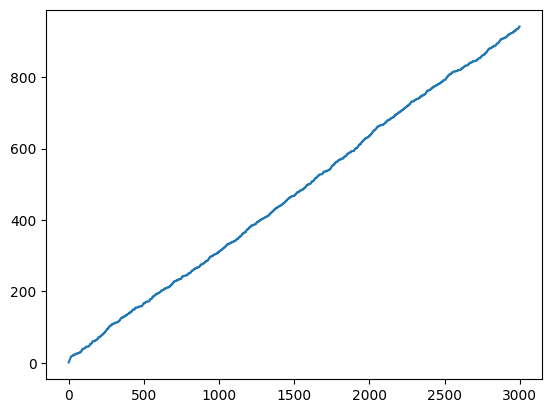

In [ ]:
plt.plot(cum_collision_num)

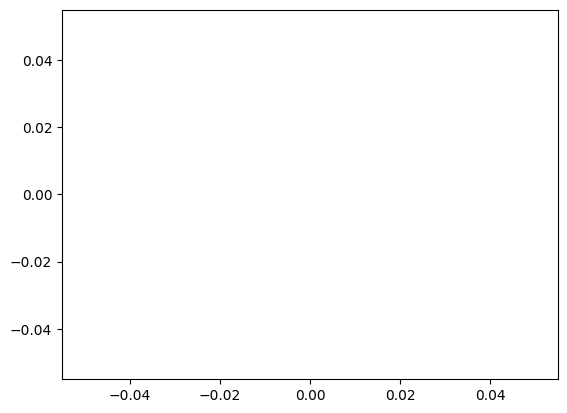

In [ ]:
plt.plot(rolling_score)

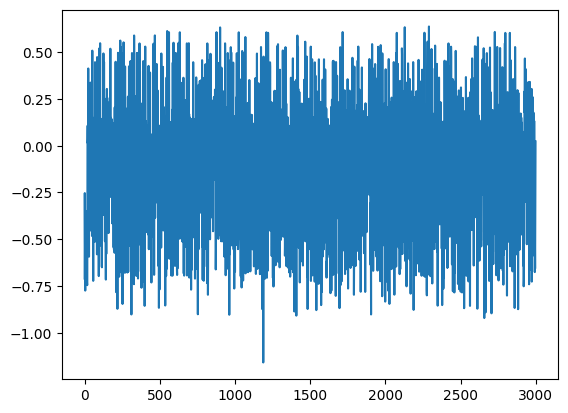

In [ ]:
plt.plot(episode_score)

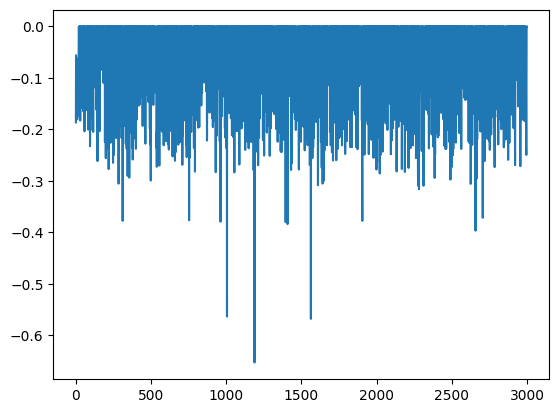

In [ ]:
plt.plot(score_safe)

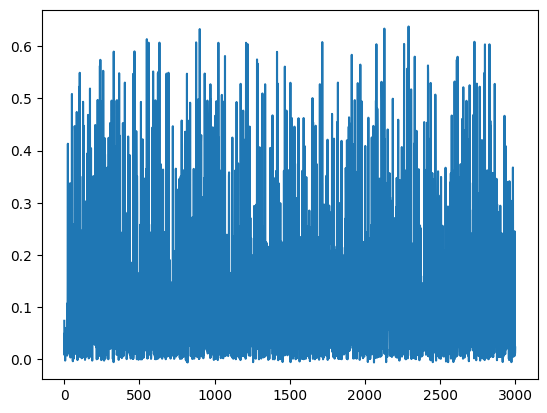

In [ ]:
plt.plot(score_efficiency)

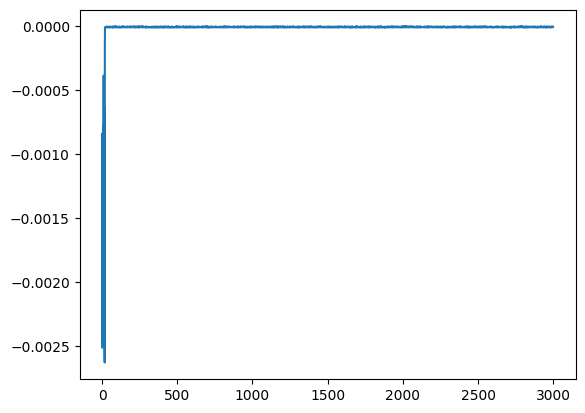

In [ ]:
plt.plot(score_comfort)